In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.simplefilter('ignore')

# 0. Load and Examine Experimental Data

In [2]:
DATA_PATH = os.path.join(".", "data")

def load_data(filename, data_path=DATA_PATH):
    file_path = os.path.join(data_path, filename)
    return pd.read_csv(file_path)

jet_df = load_data("jet_experiments.csv")
case_df = load_data("jet_cases.csv")

In [5]:
case_df

,Case,d,KineVisco
0,GW65N25,0.000565,0.000012
1,GW80N25,0.000565,0.000047
2,GW85N25,0.000565,0.000065
3,GW90N25,0.000565,0.000121
4,GW85N13,0.000281,0.000058
5,GW85N41,0.000903,0.000063
6,GW85N73,0.001762,0.000058
7,GW65N13,0.000281,0.000012


In [3]:
jet_df = pd.merge(jet_df, case_df, on=['Case'])

In [7]:
jet_df.head()

,Case,NBP,Vfr,V_j,U_w,U_w/V_j,Re_j,Re_w,Re_j/sqrt(Re_w),1/sqrt(Re_w),Lh/d,Lw/d,H/d,Lw/Lh,d,KineVisco
0,GW65N25,30.02,3.700944,14.777026,18.85,1.275599,702.1,895.6,23.46069,0.033,2.387,7.779,0.07925,3.259,0.000565,0.000012
1,GW65N25,29.96,3.696393,14.758855,21.99,1.490031,701.2,1044.9,21.69367,0.031,2.228,6.910,0.07637,3.102,0.000565,0.000012
2,GW65N25,29.84,3.687284,14.722487,25.13,1.707099,699.5,1194.1,20.24256,0.029,2.108,6.662,0.06914,3.161,0.000565,0.000012
3,GW65N25,29.63,3.671324,14.658762,28.27,1.928835,696.5,1343.4,19.00226,0.027,1.900,6.183,0.06594,3.254,0.000565,0.000012
4,GW65N25,29.56,3.665998,14.637497,31.42,2.146264,695.5,1492.7,18.00098,0.026,1.791,5.516,0.06642,3.080,0.000565,0.000012


In [7]:
jet_df.describe()

,NBP,Vfr,V_j,U_w,U_w/V_j,Re_j,Re_w,Re_j/sqrt(Re_w),1/sqrt(Re_w),Lh/d,Lw/d,H/d,Lw/Lh,d,KineVisco
count,515.000000,5.150000e+02,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,55.603883,5.612633e+00,16.675933,38.254245,2.395256,323.760130,704.080739,11.572493,0.051236,1.298296,4.104325,0.109153,3.098678,0.000581,0.000051
std,19.923363,8.781607e+00,3.863247,14.201214,1.013628,300.798954,662.876977,6.636189,0.023562,0.617489,2.104599,0.048905,0.215076,0.000321,0.000031
min,24.710000,8.540000e-07,8.722390,15.707963,0.640981,40.900000,73.600000,3.372710,0.018000,0.500000,1.282000,0.043140,2.456000,0.000281,0.000012
25%,39.850000,1.003249e+00,14.018792,25.132741,1.601404,86.200000,224.500000,6.279877,0.033140,0.790000,2.333000,0.073399,2.949000,0.000281,0.000012
50%,50.430000,3.707402e+00,16.843305,37.699112,2.283183,209.660000,486.400000,9.596060,0.045000,1.129000,3.604000,0.096680,3.103285,0.000565,0.000058
75%,70.050000,5.126933e+00,19.488534,50.265482,3.025978,473.625018,897.910000,15.384545,0.066744,1.675000,5.389258,0.133040,3.253989,0.000565,0.000065
max,100.600000,4.550411e+01,25.183197,65.970000,6.409102,1196.500000,2985.300000,35.137450,0.117000,3.461000,10.750000,0.293920,3.715000,0.001762,0.000121


In [8]:
jet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 0 to 514
Data columns (total 16 columns):
Case               515 non-null object
NBP                515 non-null float64
Vfr                515 non-null float64
V_j                515 non-null float64
U_w                515 non-null float64
U_w/V_j            515 non-null float64
Re_j               515 non-null float64
Re_w               515 non-null float64
Re_j/sqrt(Re_w)    515 non-null float64
1/sqrt(Re_w)       515 non-null float64
Lh/d               515 non-null float64
Lw/d               515 non-null float64
H/d                515 non-null float64
Lw/Lh              515 non-null float64
d                  515 non-null float64
KineVisco          515 non-null float64
dtypes: float64(15), object(1)
memory usage: 68.4+ KB


# 1. Averaged Downstream Height (H/d)

In [4]:
def reg_plot(x_name, y_name, main_title, fltr='Case', df=jet_df):
    X = np.array((df[x_name]))
    Y = np.array((df[y_name]))
    b, a, r_value, p_value, std_err = linregress(X, Y) 
    eqn = f'y={a:.2f}+({b:.2f}x), $R^2=${r_value**2:.2f}'
    
    return (ggplot(df)
     + aes(x=x_name, y=y_name, color=fltr)
     + geom_point(aes(shape='Case'))
     + stat_smooth(color=None, method='lm')
     + labs(title=main_title + '\n\n' + eqn)
    )

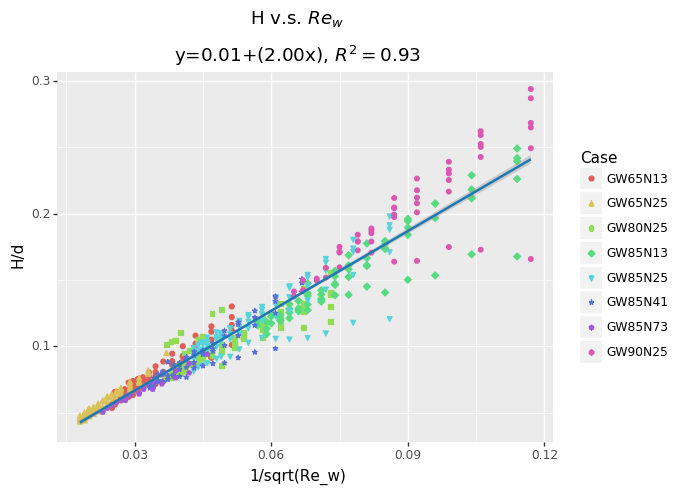

<ggplot: (290635321)>

In [10]:
reg_plot('1/sqrt(Re_w)', 'H/d', "H v.s. $Re_w$")

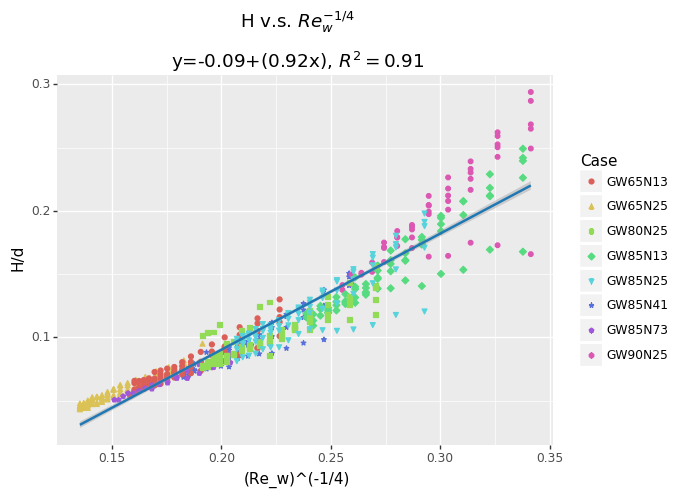

<ggplot: (302803944)>

In [20]:
jet_df['(Re_w)^(-1/4)']=jet_df['Re_w']**(-1/4)
reg_plot('(Re_w)^(-1/4)', 'H/d', "H v.s. $Re_w^{-1/4}$")

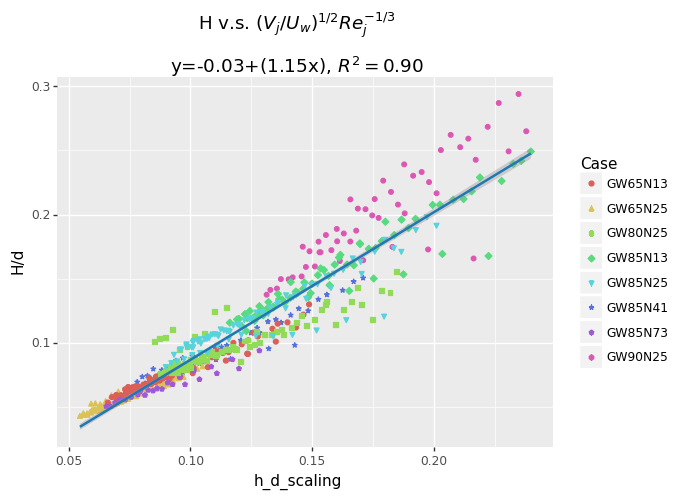

<ggplot: (-9223372036553200917)>

In [26]:
jet_df['h_d_scaling']=jet_df['U_w/V_j']**(-1/2)*jet_df['Re_j']**(-1/3)
reg_plot('h_d_scaling', 'H/d', "H v.s. $(V_j/U_w)^{1/2} Re_j^{-1/3}$")

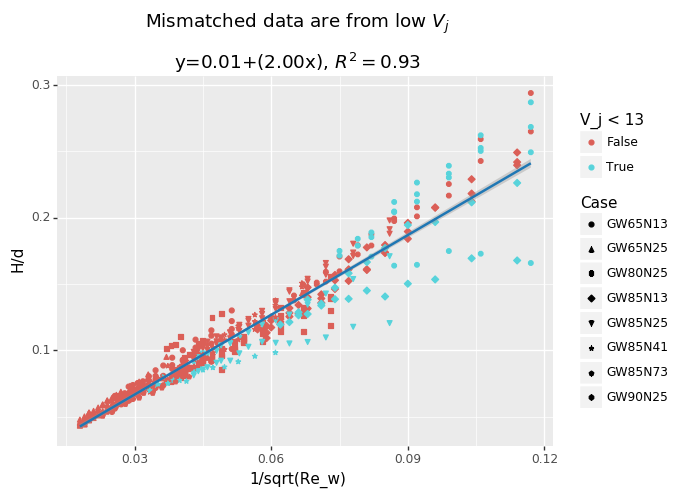

<ggplot: (294137748)>

In [16]:
reg_plot('1/sqrt(Re_w)', 'H/d', "Mismatched data are from low $V_j$", fltr='V_j < 13')

### Will low $V_j$ cause systematic biased results?
### Should blue dots be treated as outliers?

1. Split the data into two groups by $V_j=13$.
1. Find the regression line for the red dots ($V_j \ge 13$)
2. Use the above regression line to predict the $H/d$ for the blue dots ($V_j < 13$)
3. Plot the errors for the blue dots: $\delta_{H/d} = H/d_{measured} - H/d_{predicted}$.

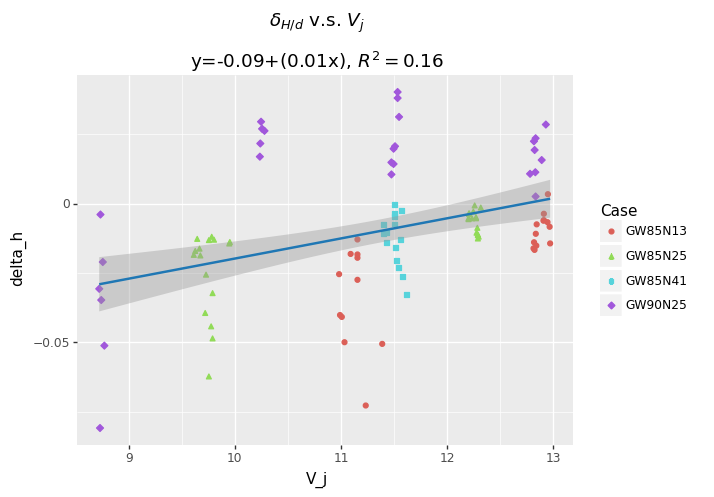

<ggplot: (-9223372036560508917)>

In [17]:
threshold = 13
X_red = np.array((jet_df[jet_df.V_j >= threshold]['1/sqrt(Re_w)']))
Y_red = np.array((jet_df[jet_df.V_j >= threshold]['H/d']))
b, a, r_value, p_value, std_err = linregress(X_red, Y_red)

jet_df['delta_h'] = jet_df['H/d'] -(a + b*jet_df['1/sqrt(Re_w)'])
reg_plot('V_j', 'delta_h', "$\delta_{H/d}$ v.s. $V_j$", df=jet_df[jet_df.V_j < threshold])

The data points are almost centered around y = 0. There is no evident that the data with $V_j<13$ should be treated as outliers.

The zero slope and almost zero intercept shows that there is low $V_j$ is not causing systematic errors on the $H/d$ results.

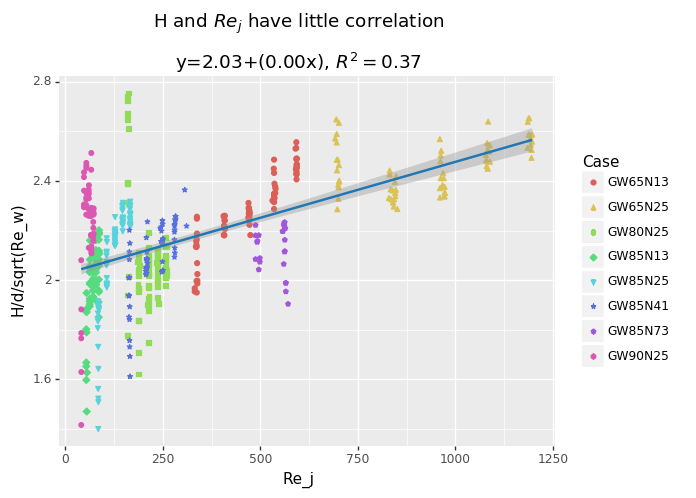

<ggplot: (306861281)>

In [261]:
jet_df['H/d/sqrt(Re_w)']=jet_df['H/d']/jet_df['1/sqrt(Re_w)']
reg_plot('Re_j', 'H/d/sqrt(Re_w)', "H and $Re_j$ have little correlation")

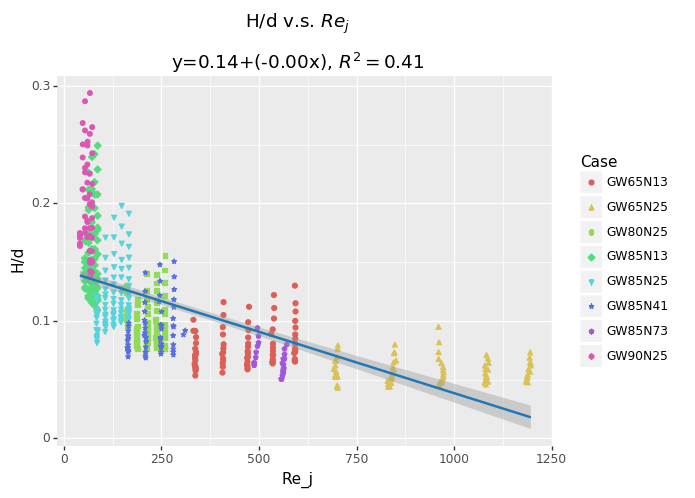

<ggplot: (-9223372036548779790)>

In [259]:
reg_plot('Re_j', 'H/d', "H/d v.s. $Re_j$")

# 2. Downstream Width (Lw/d) 

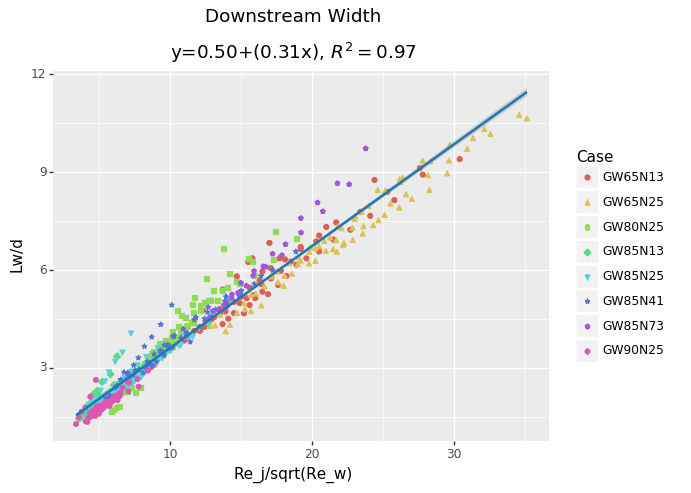

<ggplot: (306093355)>

In [249]:
reg_plot('Re_j/sqrt(Re_w)', 'Lw/d', 'Downstream Width')

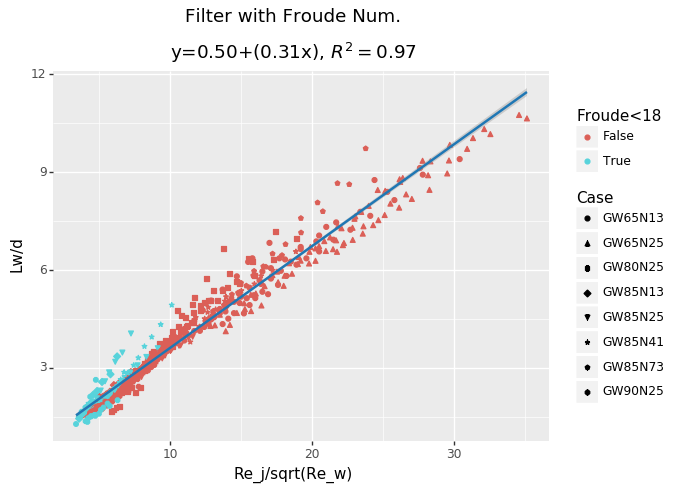

<ggplot: (-9223372036546870037)>

In [250]:
reg_plot('Re_j/sqrt(Re_w)', 'Lw/d', "Filter with Froude Num.", fltr='Froude<18')

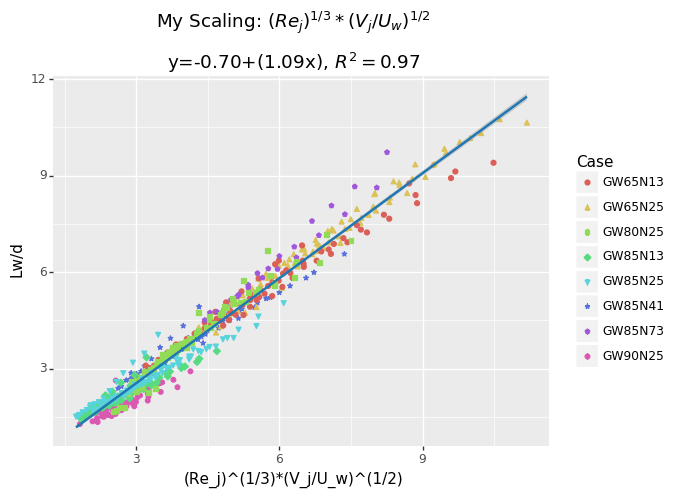

<ggplot: (301442880)>

In [17]:
reg_plot('(Re_j)^(1/3)*(V_j/U_w)^(1/2)', 'Lw/d', 'My Scaling: $(Re_j)^{1/3}*(V_j/U_w)^{1/2}$')  

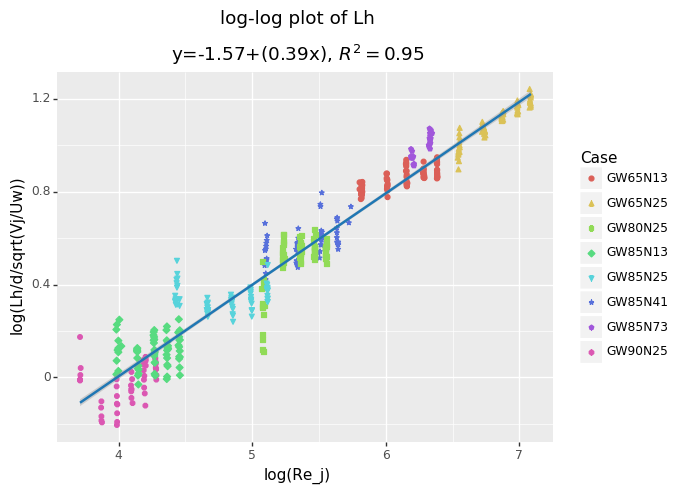

<ggplot: (-9223372036549246983)>

In [18]:
jet_df['log(Lh/d/sqrt(Vj/Uw))'] = np.log(jet_df['Lh/d']*(jet_df['U_w/V_j'])**(0.5))
jet_df['log(Re_j)'] = np.log(jet_df['Re_j'])
reg_plot('log(Re_j)','log(Lh/d/sqrt(Vj/Uw))', 'log-log plot of Lh')

# 3. Heel Length (Lh/d) 

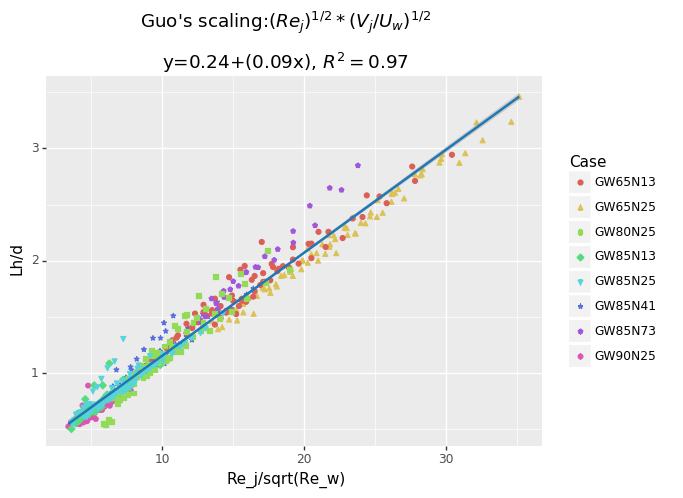

<ggplot: (298950583)>

In [13]:
reg_plot('Re_j/sqrt(Re_w)', 'Lh/d', "Guo's scaling:$(Re_j)^{1/2}*(V_j/U_w)^{1/2}$")

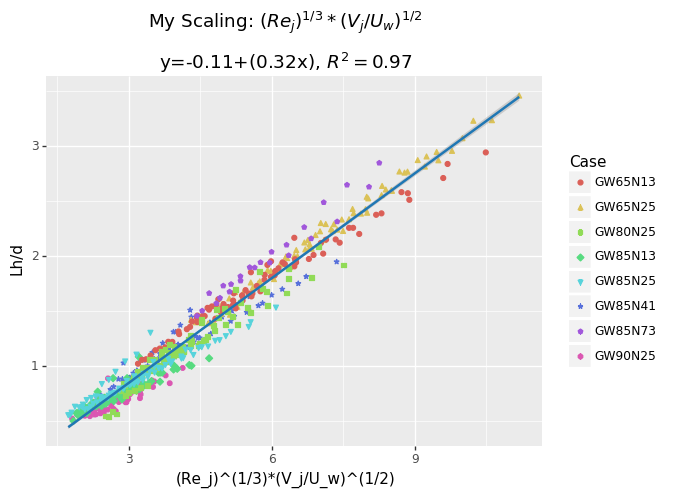

<ggplot: (-9223372036553209421)>

In [14]:
jet_df['(Re_j)^(1/3)*(V_j/U_w)^(1/2)'] = (jet_df['Re_j'])**(1/3)/np.sqrt(jet_df['U_w/V_j'])

reg_plot('(Re_j)^(1/3)*(V_j/U_w)^(1/2)', 'Lh/d', 'My Scaling: $(Re_j)^{1/3}*(V_j/U_w)^{1/2}$')  

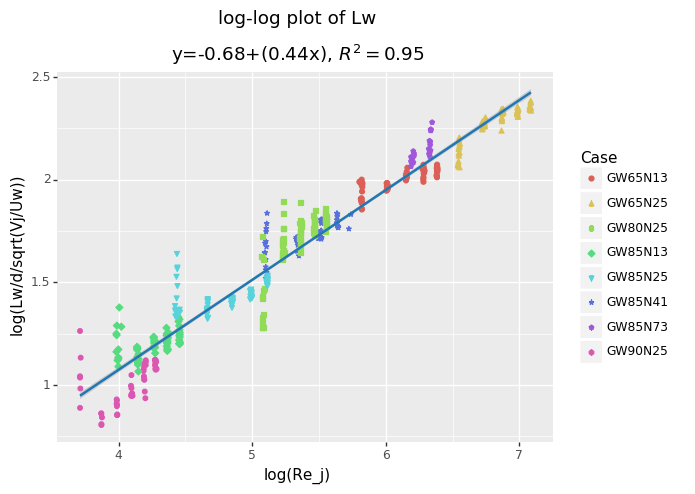

<ggplot: (306391174)>

In [17]:
jet_df['log(Lw/d/sqrt(Vj/Uw))'] = np.log(jet_df['Lw/d']*(jet_df['U_w/V_j'])**(0.5))
# jet_df['log(Re_j)'] = np.log(jet_df['Re_j'])
reg_plot('log(Re_j)','log(Lw/d/sqrt(Vj/Uw))', 'log-log plot of Lw')

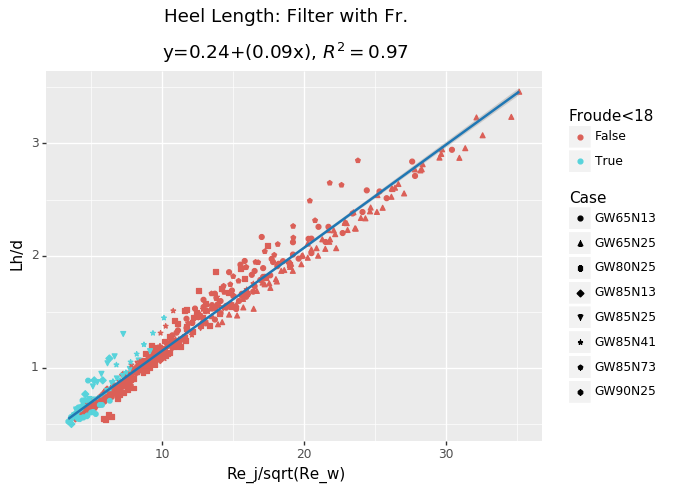

<ggplot: (307905663)>

In [251]:
reg_plot('Re_j/sqrt(Re_w)', 'Lh/d', "Heel Length: Filter with Fr.", fltr='Froude<18')


From the figures in Section 4, we see that $Lw/Lh$ is a decreasing function of $U_w/V_j$, specifically, we speculate that
$$ Lw/Lh = f(U_w/V_j) = 3.6 - 0.35\sqrt{U_w/V_j} \propto O((U_w/V_j)^{1/2}).$$

With this information, let's scale Lh with
$$ \frac{Lh}{d} = \frac{Lw}{d}\cdot \frac{1}{f(U_w/V_j)} \approx \frac{Re_j}{\sqrt{Re_w} \cdot f(U_w/V_j)}$$

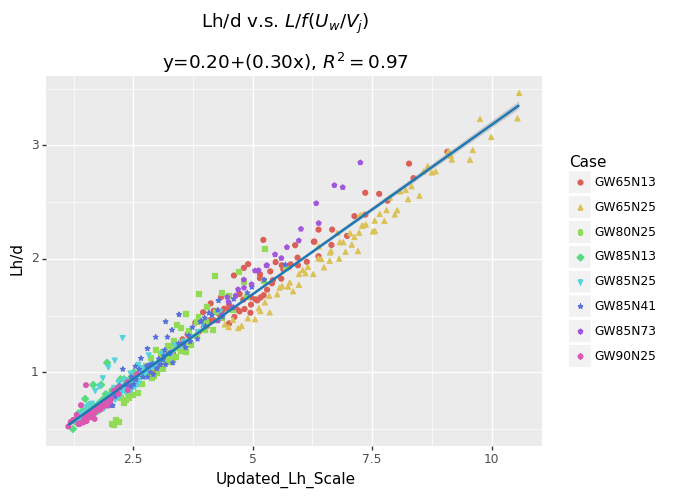

<ggplot: (307786076)>

In [253]:
jet_df['Updated_Lh_Scale'] = jet_df['Re_j/sqrt(Re_w)']/(3.63-0.35*np.sqrt(jet_df['U_w/V_j']))
reg_plot('Updated_Lh_Scale', 'Lh/d', 'Lh/d v.s. $L/f(U_w/V_j)$')

The new Lh scale looks fine.

If we only look at the scaling, and ignore the constant in $f(U_w/V_j)$, then the scaling of $Lh/d$ would look like:
$$ \frac{Lh}{d} \approx \frac{Re_j}{\sqrt{Re_w \cdot (U_w/V_j)}} $$

Figure below shows such a scaling. It doesn't work as well as the above two attemps.

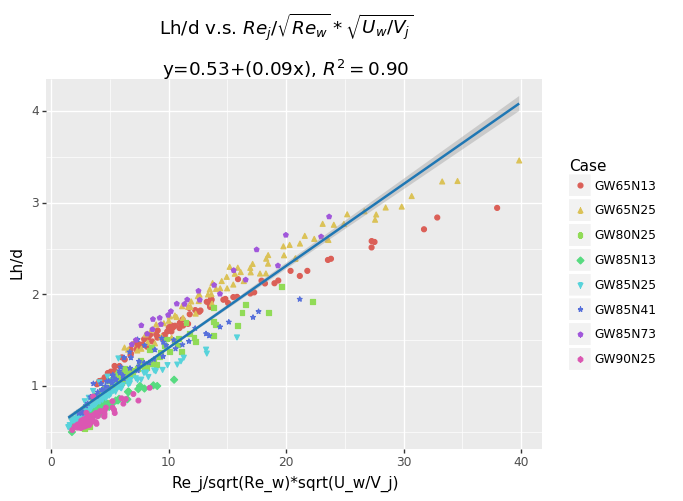

<ggplot: (305127183)>

In [254]:
jet_df['Re_j/sqrt(Re_w)*sqrt(U_w/V_j)'] = jet_df['Re_j/sqrt(Re_w)']/np.sqrt(jet_df['U_w/V_j'])

reg_plot('Re_j/sqrt(Re_w)*sqrt(U_w/V_j)', 'Lh/d', 'Lh/d v.s. $Re_j/\sqrt{Re_w}*\sqrt{U_w/V_j}$')

## PCA Analysis 

In [269]:
from sklearn.decomposition import PCA

pca = PCA()
X = np.array(jet_df[["U_w/V_j", "Re_j", "Re_w", "1/sqrt(Re_w)", 
                    "Re_j/sqrt(Re_w)"]])
X_projected = pca.fit(X)
pca.explained_variance_ratio_

array([9.61439557e-01, 3.85537878e-02, 5.96272190e-06, 6.92391783e-07,
       2.19749321e-10])

# 4. Width/Lh Ratio 

There is no direct relation between the $Lw/Lh$ ratio and the two Reynolds numbers.

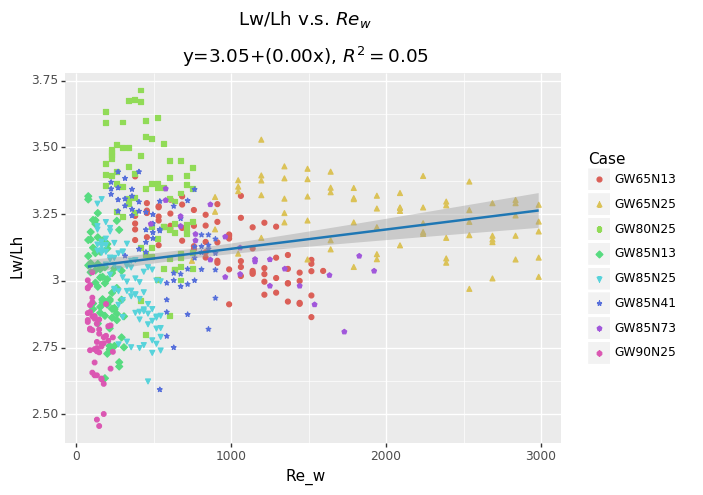

<ggplot: (305953228)>

In [257]:
reg_plot('Re_w', 'Lw/Lh', "Lw/Lh v.s. $Re_w$")

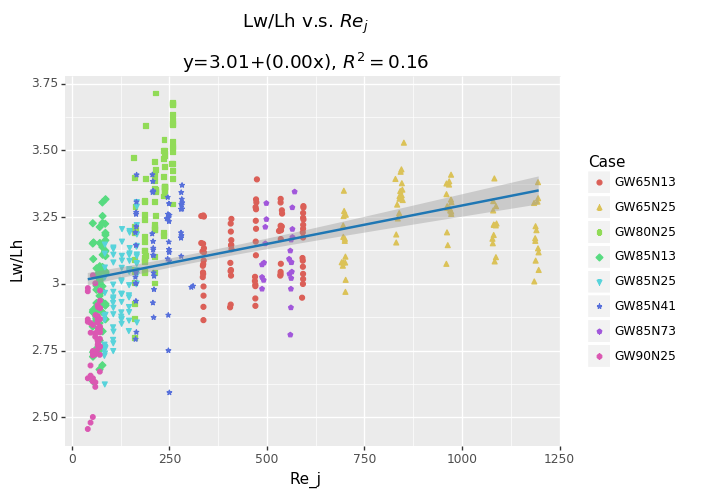

<ggplot: (-9223372036549199658)>

In [258]:
reg_plot('Re_j', 'Lw/Lh', "Lw/Lh v.s. $Re_j$")

However, once we plot $Lw/Lh$ over $U_w/V_j$, we can see that $Lw/Lh$ decreases with $U_w/V_j$:

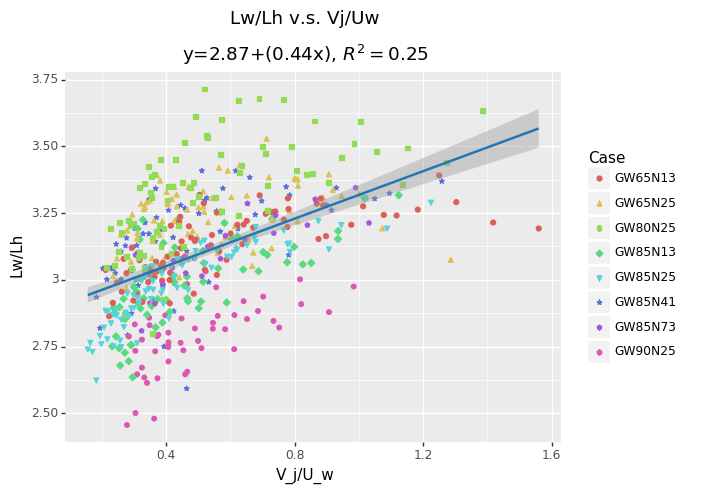

<ggplot: (-9223372036547640204)>

In [28]:
jet_df['V_j/U_w'] = jet_df['U_w/V_j']**(-1)
reg_plot('V_j/U_w', 'Lw/Lh', 'Lw/Lh v.s. Vj/Uw')

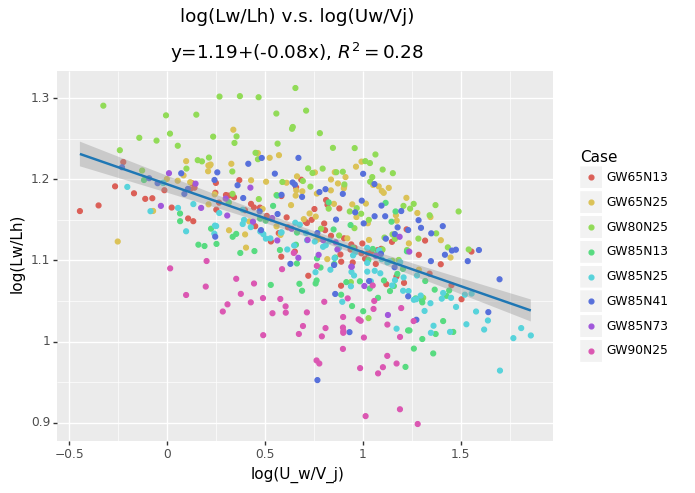

<ggplot: (306809583)>

In [172]:
jet_df['log(U_w/V_j)'] = np.log(jet_df['U_w/V_j'])
jet_df['log(Lw/Lh)'] = np.log(jet_df['Lw/Lh'])
reg_plot('log(U_w/V_j)', 'log(Lw/Lh)', 'log(Lw/Lh) v.s. log(Uw/Vj)')

The relation between $Lw/Lh$ and $\sqrt{U_w/V_j}$ looks more linear:

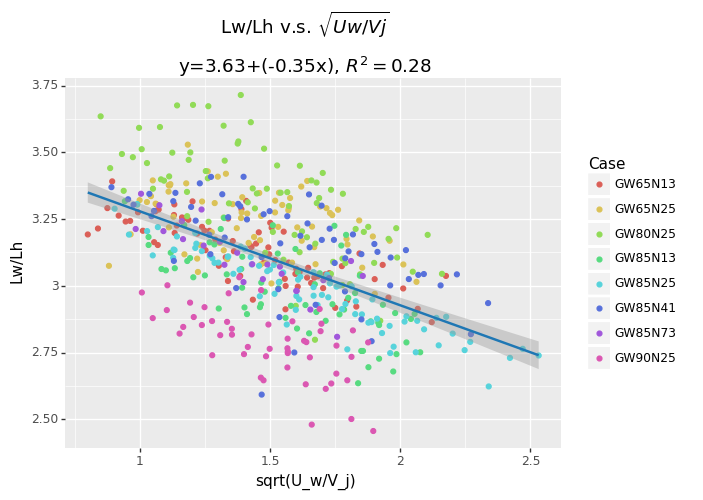

<ggplot: (-9223372036548762887)>

In [168]:
jet_df['sqrt(U_w/V_j)'] = np.sqrt(jet_df['U_w/V_j'])

reg_plot('sqrt(U_w/V_j)', 'Lw/Lh', "Lw/Lh v.s. $\sqrt{Uw/Vj}$")

# 5. Spread of Testing Cases

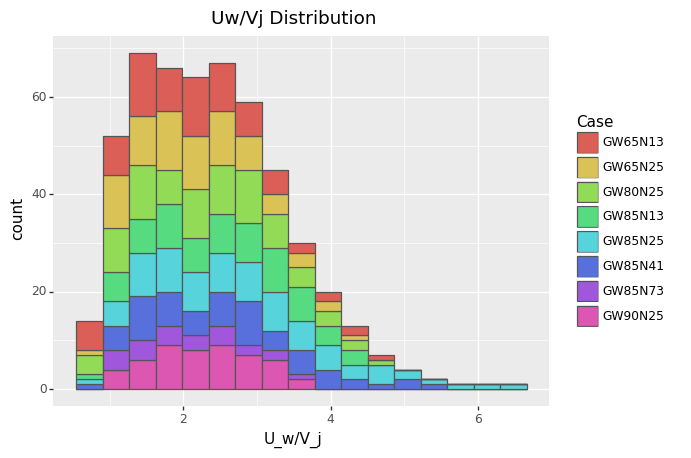

<ggplot: (306500086)>

In [164]:
(ggplot(jet_df)
 + aes(x='U_w/V_j', fill='Case')
 + geom_histogram(color='#555555')
 + labs(title="Uw/Vj Distribution")
)

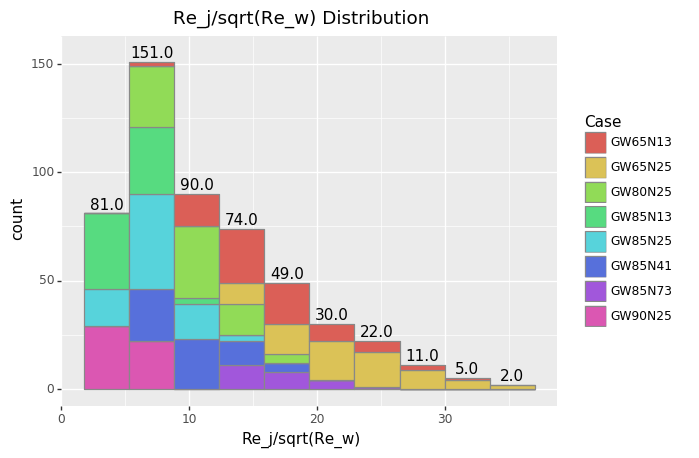

<ggplot: (-9223372036549410507)>

In [165]:
(ggplot(jet_df)
 + aes(x='Re_j/sqrt(Re_w)')
 + geom_histogram(aes(fill="Case"), bins=10, color='#888888')
 + stat_bin(
    aes(label='stat(count)', y="4+stat(count)"),
    geom="text",
    bins=10
 )
 + labs(title="Re_j/sqrt(Re_w) Distribution")
)